In [1]:
import os
import io
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import cudf

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import tensorflow as tf
from tensorflow.keras import layers

# Load Data

In [2]:
%%time
train = cudf.read_csv('../input/tabular-playground-series-oct-2021/train.csv').set_index("id")
test = cudf.read_csv('../input/tabular-playground-series-oct-2021/test.csv').set_index("id")
sample_submission = cudf.read_csv("../input/tabular-playground-series-oct-2021/sample_submission.csv").to_pandas()

CPU times: user 4.34 s, sys: 2.39 s, total: 6.72 s
Wall time: 43.4 s


In [3]:
feature_cols = test.columns.tolist()

cnt_features = []
cat_features = []

for col in feature_cols:
    if train[col].dtype=='float64':
        cnt_features.append(col)
    else:
        cat_features.append(col)
        
        
start_mem = (train.memory_usage(deep=True) / 1024 ** 2).sum()

train[cnt_features] = train[cnt_features].astype('float32')
train[cat_features] = train[cat_features].astype('uint8')
test[cnt_features] = test[cnt_features].astype('float32')
test[cat_features] = test[cat_features].astype('uint8')

end_mem = (train.memory_usage(deep=True) / 1024 ** 2).sum()


train = train.to_pandas()
test = test.to_pandas()

In [4]:
print("Mem. usage decreased from {:.2f} MB to {:.2f} MB ({:.2f}% reduction)".format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))

Mem. usage decreased from 2189.64 MB to 973.70 MB (55.53% reduction)


# Categorize Data

In [5]:
%%time
bins = 128
n = 0
bins_list = []

bins_list.append(-np.inf)
for i in range(1,bins):
    n += 1./bins
    bins_list.append(n)
bins_list.append(np.inf)

labels = [i for i in range(bins)]
for col in cnt_features:
    train[col] = pd.cut(train[col], bins=bins_list, labels=labels)
    test[col] = pd.cut(test[col], bins=bins_list, labels=labels)
    
train.head()

CPU times: user 38.9 s, sys: 20 s, total: 58.9 s
Wall time: 59 s


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f276,f277,f278,f279,f280,f281,f282,f283,f284,target
id,,,,,,,,,,,,,,,,,,,,,
0,26,52,22,28,54,60,52,78,68,18,...,0,1,0,0,0,0,0,0,0,1
1,23,60,1,27,79,56,29,87,36,30,...,0,1,0,0,0,0,0,0,0,1
2,23,39,41,26,77,39,63,96,68,36,...,0,0,0,1,1,0,0,0,0,1
3,23,63,1,28,97,56,55,99,61,33,...,0,0,0,0,1,0,0,0,0,1
4,22,63,1,70,80,71,14,71,9,20,...,0,1,1,0,1,0,0,1,0,1


In [6]:
train[cnt_features] = train[cnt_features].astype('uint8')
test[cnt_features] = test[cnt_features].astype('uint8')

In [7]:
memory_usage = train.memory_usage(deep=True) / 1024 ** 2
print("Mem. usage decreased from {:.2f} MB to {:.2f} MB ({:.2f}% reduction)".format(end_mem, memory_usage.sum(), 100 * (end_mem - memory_usage.sum()) / end_mem))

Mem. usage decreased from 973.70 MB to 287.06 MB (70.52% reduction)


In [8]:
x1 = train[cnt_features].values
x2 = train[cat_features].values
y  = train['target'].values

# Neural Network Model

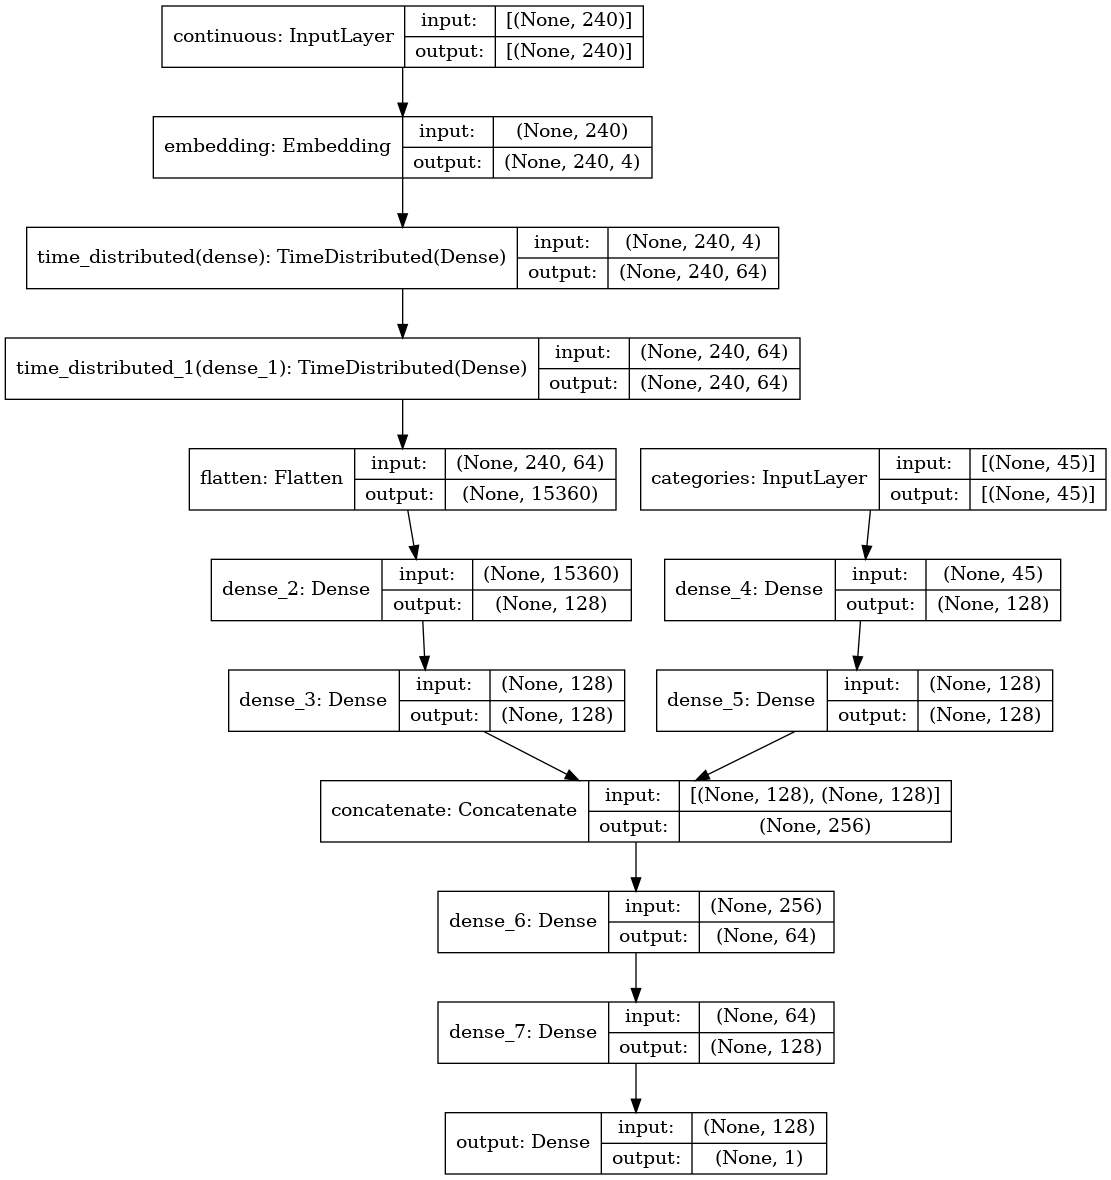

In [9]:
def get_model():
    AF = "relu"
    input_1 = layers.Input(shape=(x1.shape[-1]), name="continuous")
    x_1 = layers.Embedding(input_dim=bins, output_dim=4)(input_1)
    x_1 = layers.TimeDistributed(layers.Dense(64, activation=AF))(x_1)
    x_1 = layers.TimeDistributed(layers.Dense(64, activation=AF))(x_1)
    x_1 = layers.Flatten()(x_1)
    x_1 = layers.Dense(128, activation=AF)(x_1)
    x_1 = layers.Dense(128, activation=AF)(x_1)
    
    input_2 = layers.Input(shape=x2.shape[-1], name="categories")
    x_2 = layers.Dense(128, activation=AF)(input_2)
    x_2 = layers.Dense(128, activation=AF)(x_2)

    x = layers.Concatenate()([x_1,x_2])
    x = layers.Dense(64, activation=AF)(x)
    x = layers.Dense(128, activation=AF)(x)
    output = layers.Dense(1, activation="sigmoid", name="output")(x)

    model = tf.keras.Model([input_1,input_2], output)
    return model


model = get_model()
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["AUC"])
    
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
cb_es = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=4, mode="max", restore_best_weights=True, verbose=1)
cb_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=2, mode="max", min_lr=0.0001, verbose=1)

history = model.fit((x1,x2), 
                    y, 
                    epochs=20, 
                    validation_split=0.2, 
                    batch_size=512, 
                    validation_batch_size=512,
                    callbacks=[cb_es, cb_lr])

Epoch 1/20
1563/1563 [==============================] - 21s 12ms/step - loss: 0.5209 - auc: 0.8130 - val_loss: 0.4752 - val_auc: 0.8499
Epoch 2/20
1563/1563 [==============================] - 18s 12ms/step - loss: 0.4706 - auc: 0.8518 - val_loss: 0.4692 - val_auc: 0.8516
Epoch 3/20
1563/1563 [==============================] - 19s 12ms/step - loss: 0.4648 - auc: 0.8550 - val_loss: 0.4673 - val_auc: 0.8524
Epoch 4/20
1563/1563 [==============================] - 18s 11ms/step - loss: 0.4623 - auc: 0.8565 - val_loss: 0.4671 - val_auc: 0.8526
Epoch 5/20
1563/1563 [==============================] - 18s 12ms/step - loss: 0.4615 - auc: 0.8566 - val_loss: 0.4693 - val_auc: 0.8524
Epoch 6/20
1563/1563 [==============================] - 19s 12ms/step - loss: 0.4592 - auc: 0.8580 - val_loss: 0.4672 - val_auc: 0.8525

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/20
1563/1563 [==============================] - 18s 12ms/step - loss: 0.4548 - auc: 0.8604 - va

# Embeddings Projection

 You can uppload these two files (`vecs.tsv` and `meta.tsv`) on http://projector.tensorflow.org/ to visualize embedding layer

In [11]:
e = model.layers[1]
weights = e.get_weights()[0]
print(weights.shape)

words = [f"{i} ({np.round(bins_list[i],3)}-{np.round(bins_list[i+1],3)})" for i in labels]

vecs = io.open('vecs.tsv', 'w', encoding='utf-8')
meta = io.open('meta.tsv', 'w', encoding='utf-8')
for i in range(bins):
    vecs.write(words[i] + "\n")
    meta.write('\t'.join([str(x) for x in weights[i]]) + "\n")
vecs.close()
meta.close()

(128, 4)


# Predict

In [12]:
preds = model.predict((test[cnt_features].values, test[cat_features].values))

# Plot Predictions

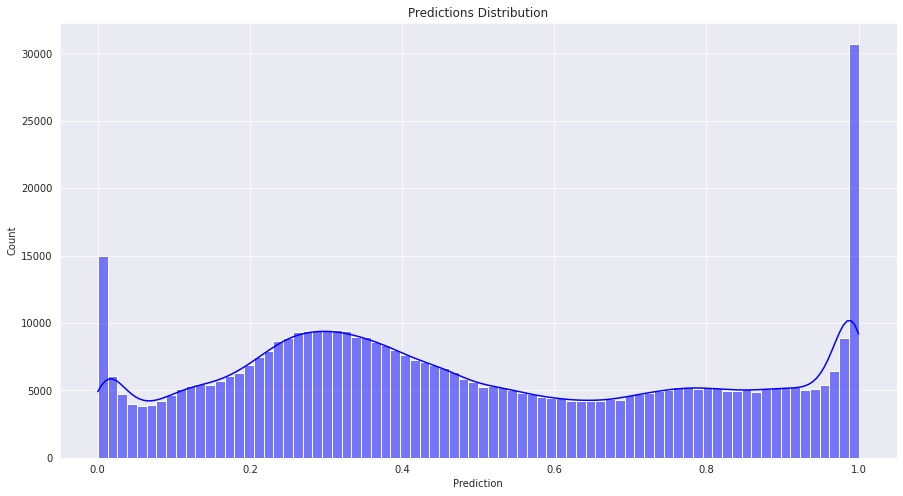

In [13]:
plt.figure(figsize=(15,8))
sns.histplot(x=preds.reshape(-1), kde=True, color="blue")
plt.title("Predictions Distribution")
plt.xlabel("Prediction")
plt.show()

# Submission

In [ ]:
sample_submission['target'] = np.squeeze(preds)
sample_submission.to_csv("submission.csv", index=False)